In [1]:
from model import *
from utils import * 
from optimizer import *
from visualize import *
import random
from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import normalized_mutual_info_score as mis
import numpy as np

## Initialize dataset

In [2]:
dataset = TUDataset(root='data/TUDataset', name='MUTAG')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')


Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2


In [3]:
max_n_nodes = get_max_n_nodes(dataset)
print(f'Max number of nodes: {max_n_nodes}')

Max number of nodes: 28


In [4]:
dataset = update_dataset(dataset, max_n_nodes)

In [5]:
torch.manual_seed(12345)
random.shuffle(dataset)

train_dataset = dataset[:150]
test_dataset = dataset[150:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 150
Number of test graphs: 38


In [6]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

## Initialize & train a model

In [7]:
n_nodes = 28
feat_dim = 7
hidden1 = 32
hidden2 = 16
dropout = 0.0
lr = 1e-4
epochs = 50
save_file = 'model'

In [8]:
model = GCNModelVAE(n_nodes, feat_dim, hidden1, hidden2)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [9]:
log = fit(model, optimizer, train_loader, test_loader, epochs, save_file)

Training for 50 epochs: 100%|███████████████████| 50/50 [00:07<00:00,  7.03it/s]

Optimization Finished!
Best epoch: 37 , Best test set loss: 80.0864


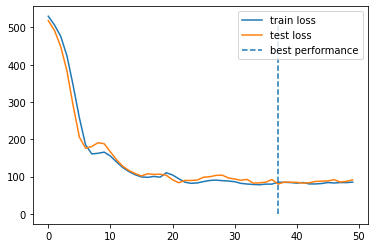

In [10]:
performance_plot(log)

## Visualize results

In [11]:
model.state_dict = torch.load('model')

In [12]:
# get random graph as Data object
data = random.choice(list(train_loader))
# the Data object is a batch => take a random index from the batch
n = random.choice(range(len(data.y)))

recovered, mu, logvar = model(data.x, data.edge_index, data.batch)
adj = data.adj
mask = create_mask(n_nodes)

In [13]:
recovered = (recovered.view(-1, n_nodes, n_nodes)*mask).detach().numpy()[n]
adj = (adj.view(-1, n_nodes, n_nodes)*mask).detach().numpy()[n]

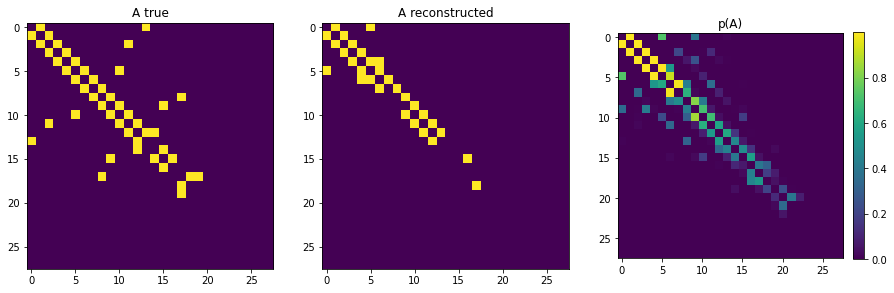

In [14]:
visualize_recon_adj(recovered, adj)

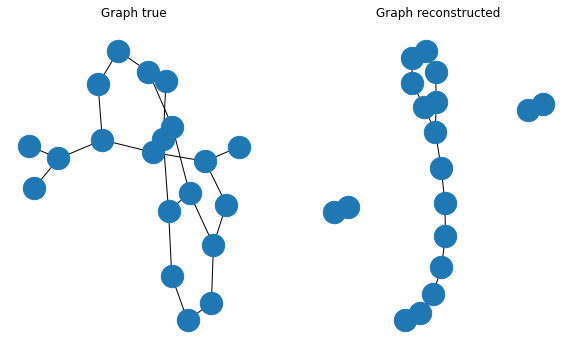

In [15]:
visualize_recon_graph(recovered, adj)

## Latent space (2D case)

In [16]:
if model.latent_dim == 2:
    model.state_dict = torch.load('model')
    all_loader = DataLoader(dataset, batch_size=10**10, shuffle=True)
    data = next(iter(all_loader))
        
    mu, logvar = model.encode(data.x, data.edge_index, data.batch)
    z = model.reparameterize(mu, logvar).detach().numpy()
    
    visualize_z_space(z, data.y)

## Inference task I: $argmax_{A}p(A|y)$ 

In [17]:
y = 0

In [18]:
mask = create_mask(n_nodes)

In [19]:
z_y = get_cluster(model, dataset, y)
z_centre = cluster_centre(z_y)

In [20]:
if model.latent_dim == 2:
    visualize_z_space(z, data.y, z_centre.detach().numpy())

In [21]:
a_y = model.decode(z_centre).view(model.n_nodes,model.n_nodes)
a_y = (a_y*mask).detach().numpy().squeeze()

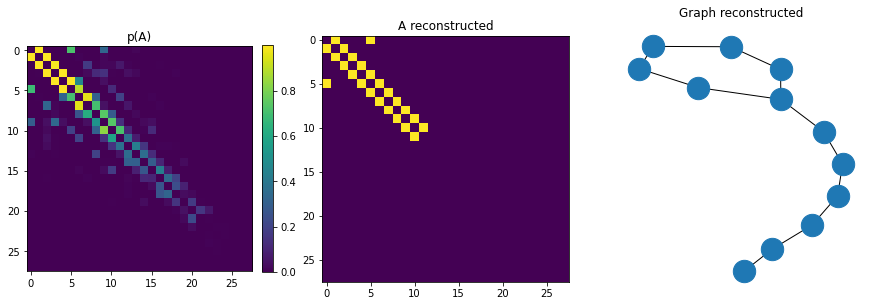

In [22]:
visualize_adj_graph(a_y)

## Inference task II: $argmax_{z_i \in Z} MI(z_i, Y)$ 

In [23]:
loader = DataLoader(dataset, batch_size=10**10, shuffle=True)

In [24]:
data = next(iter(loader))

In [25]:
mu, logvar = model.encode(data.x, data.edge_index, data.batch)
z = model.reparameterize(mu, logvar).detach().numpy()

In [26]:
cs = np.abs(cosine_similarity(z.T)).mean()
print('Average cosine similarity between latent variables: {:.2f}'.format(cs))

Average cosine similarity between latent variables: 0.26


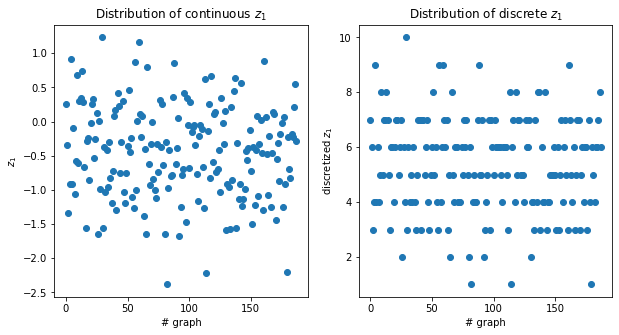

In [27]:
vis_digitized(z[:,0], digitize_z(z[:,0]))

In [30]:
# compute MI(z_i, Y) for each z_i in Z
mi = []
for i in range(hidden2):
    a = digitize_z(z[:,i])
    b = data.y.detach().numpy()
    mi.append(mis(a,b))

Text(0.5, 1.0, 'MI($z_i$, Y)')

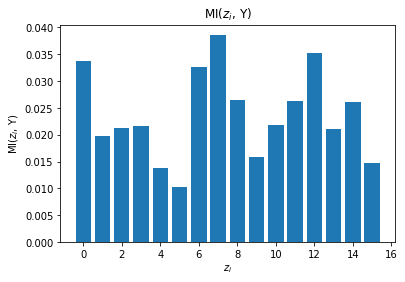

In [31]:
plt.bar(x = range(len(mi)), height = mi)
plt.xlabel('$z_i$')
plt.ylabel('MI($z_i$, Y)')
plt.title('MI($z_i$, Y)')

In [32]:
# range of z_i with max MIS
a = z[:,np.argmax(mi)].min()
b = z[:,np.argmax(mi)].max()

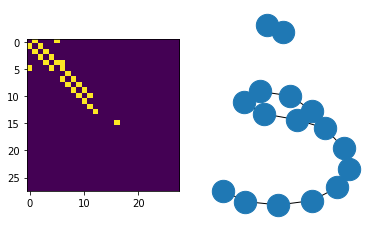

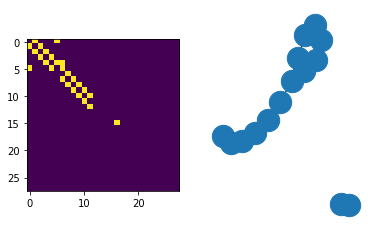

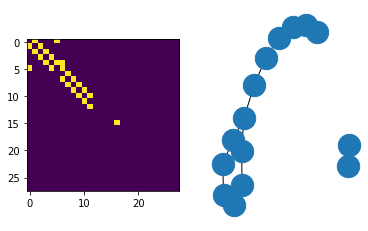

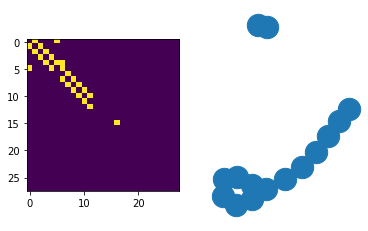

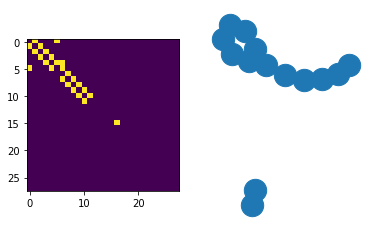

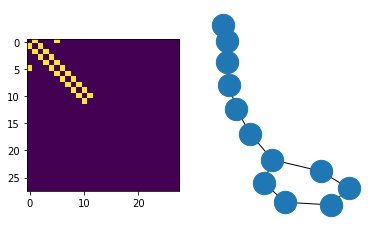

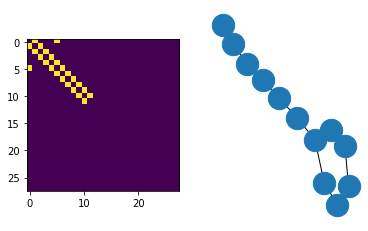

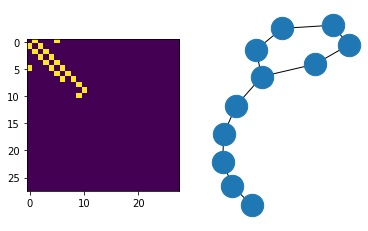

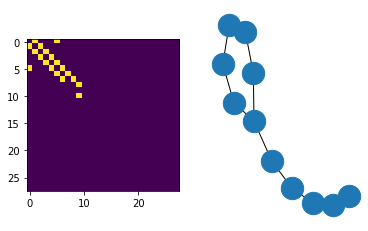

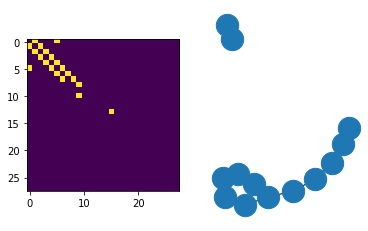

In [33]:
# Vary z_i across its range and see how adajcency matrix changes
for value in np.arange(a, b, (b-a)/10):
    z = torch.zeros(hidden2)
    z[i] = value
    adj = ((model.decode(z).view(28,28)*mask).detach().numpy() > 0.5)*1
    f, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(adj.squeeze())
    show_graphs(adj.squeeze(), ax = ax2)